In [1]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"
local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2023-06-09 15:09:59--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.194.100.219, 2600:1409:9800:984::317f, 2600:1409:9800:98c::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.194.100.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   113MB/s    in 7.2s    

2023-06-09 15:10:06 (110 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [3]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


In [4]:
to_create = [
    '/tmp/cats-v-dogs',
    '/tmp/cats-v-dogs/training',
    '/tmp/cats-v-dogs/testing',
    '/tmp/cats-v-dogs/training/cats',
    '/tmp/cats-v-dogs/training/dogs',
    '/tmp/cats-v-dogs/testing/cats',
    '/tmp/cats-v-dogs/testing/dogs'
]

for directory in to_create:
    try:
        os.mkdir(directory)
        print(directory, 'created')
    except:
        print(directory, 'failed')

/tmp/cats-v-dogs created
/tmp/cats-v-dogs/training created
/tmp/cats-v-dogs/testing created
/tmp/cats-v-dogs/training/cats created
/tmp/cats-v-dogs/training/dogs created
/tmp/cats-v-dogs/testing/cats created
/tmp/cats-v-dogs/testing/dogs created


In [5]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    all_files = []
    
    for file_name in os.listdir(SOURCE):
        file_path = SOURCE + file_name

        if os.path.getsize(file_path):
            all_files.append(file_name)
        else:
            print('{} is zero length, so ignoring'.format(file_name))
    
    n_files = len(all_files)
    split_point = int(n_files * SPLIT_SIZE)
    
    shuffled = random.sample(all_files, n_files)
    
    train_set = shuffled[:split_point]
    test_set = shuffled[split_point:]
    
    for file_name in train_set:
        copyfile(SOURCE + file_name, TRAINING + file_name)
        
    for file_name in test_set:
        copyfile(SOURCE + file_name, TESTING + file_name)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)


666.jpg is zero length, so ignoring
11702.jpg is zero length, so ignoring


In [6]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), input_shape=(150, 150, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

In [8]:
TRAINING_DIR = '/tmp/cats-v-dogs/training'
train_datagen = ImageDataGenerator(
    rescale=1 / 255,
    rotation_range=40,
    width_shift_range=.2,
    height_shift_range=.2,
    shear_range=.2,
    zoom_range=.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size=128,
    class_mode='binary',
    target_size=(150, 150)
)

VALIDATION_DIR = '/tmp/cats-v-dogs/testing'
validation_datagen = ImageDataGenerator(
    rescale=1 / 255,
    rotation_range=40,
    width_shift_range=.2,
    height_shift_range=.2,
    shear_range=.2,
    zoom_range=.2,
    horizontal_flip=True,
    fill_mode='nearest'

)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=128,
    class_mode='binary',
    target_size=(150, 150)
)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [9]:
import warnings
warnings.filterwarnings('ignore')
print('warnings ignored')

history = model.fit_generator(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=validation_generator)

warnings ignored
Epoch 1/15
176/176 [==============================] - 421s 2s/step - loss: 0.6783 - acc: 0.5689 - val_loss: 0.8896 - val_acc: 0.5104
Epoch 2/15
176/176 [==============================] - 411s 2s/step - loss: 0.6358 - acc: 0.6406 - val_loss: 0.6278 - val_acc: 0.6468
Epoch 3/15
176/176 [==============================] - 412s 2s/step - loss: 0.5988 - acc: 0.6722 - val_loss: 0.5994 - val_acc: 0.6796
Epoch 4/15
176/176 [==============================] - 410s 2s/step - loss: 0.5726 - acc: 0.6947 - val_loss: 0.5596 - val_acc: 0.7236
Epoch 5/15
176/176 [==============================] - 408s 2s/step - loss: 0.5567 - acc: 0.7094 - val_loss: 0.5571 - val_acc: 0.7044
Epoch 6/15
176/176 [==============================] - 411s 2s/step - loss: 0.5355 - acc: 0.7301 - val_loss: 0.5167 - val_acc: 0.7552
Epoch 7/15
176/176 [==============================] - 409s 2s/step - loss: 0.5189 - acc: 0.7414 - val_loss: 0.5475 - val_acc: 0.7180
Epoch 8/15
176/176 [==============================] 

Text(0.5, 1.0, 'Training and validation loss')

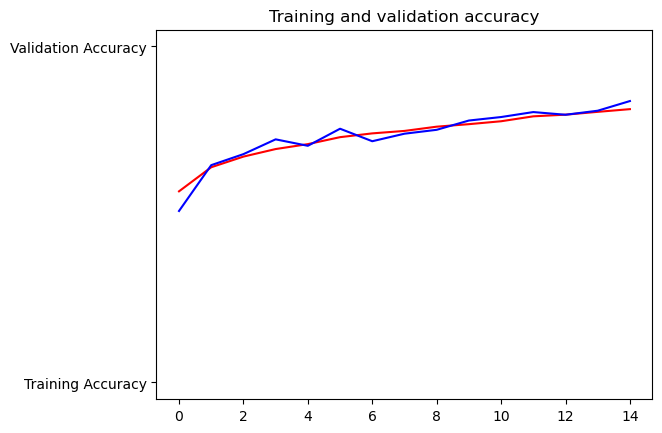

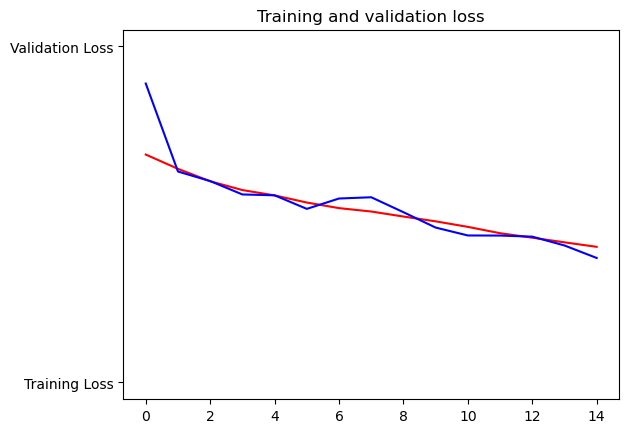

In [10]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#list of list results on training and test data
# sets for each training epoch

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs


# Plotting training and validation accuracy per epoch

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()


# Plotting training and validation loss per epoch

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

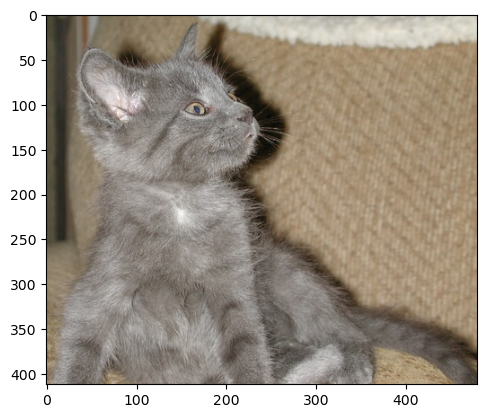

1/1 [==============================] - 0s 163ms/step
 is a dog


In [11]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt



cat1 = load_img('/kaggle/input/catdogtest/catdog/cat1.jpg')
plt.imshow(cat1)
plt.show()

im = cv2.imread('/kaggle/input/catdogtest/catdog/cat1.jpg')
im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (150, 150)).astype(np.float32)
im = np.expand_dims(im, axis =0)

cat1_predict = model.predict(im)

if cat1_predict[0]>0.5:
    print(" is a dog")
else:
    print(" is a cat")

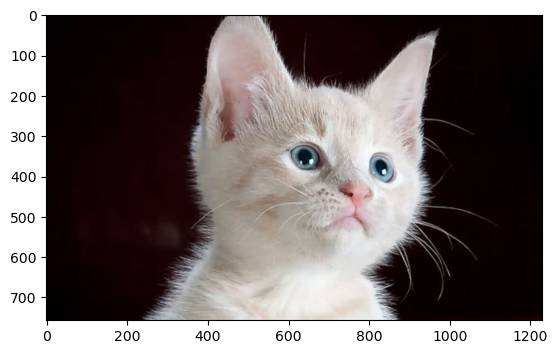

1/1 [==============================] - 0s 36ms/step
 is a cat


In [12]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt



cat2 = load_img('/kaggle/input/catdogtest/catdog/cat2.jpg')
plt.imshow(cat2)
plt.show()

im = cv2.imread('/kaggle/input/catdogtest/catdog/cat2.jpg')
im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (150, 150)).astype(np.float32)
im = np.expand_dims(im, axis =0)

cat1_predict = model.predict(im)

if cat1_predict[0]>0.5:
    print(" is a dog")
else:
    print(" is a cat")

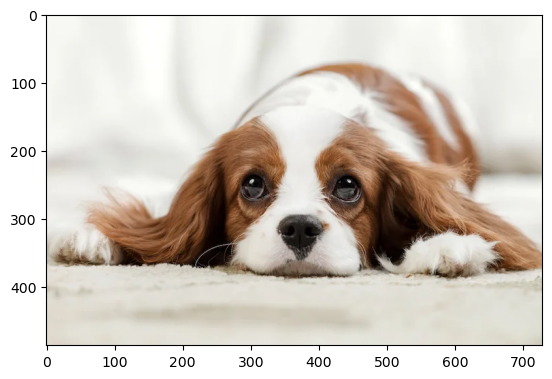

1/1 [==============================] - 0s 29ms/step
 is a dog


In [13]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt



dog1 = load_img('/kaggle/input/catdogtest/catdog/dog1.jpeg')
plt.imshow(dog1)
plt.show()

im = cv2.imread('/kaggle/input/catdogtest/catdog/dog1.jpeg')
im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (150, 150)).astype(np.float32)
im = np.expand_dims(im, axis =0)

cat1_predict = model.predict(im)

if cat1_predict[0]>0.5:
    print(" is a dog")
else:
    print(" is a cat")

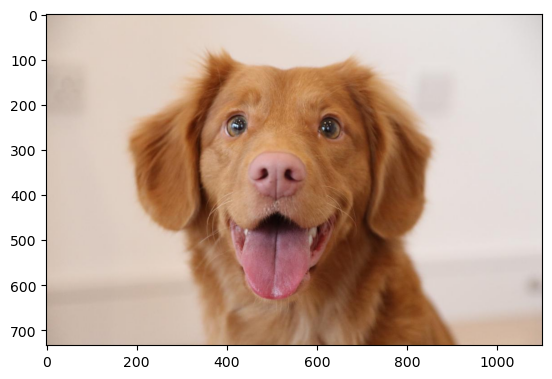

1/1 [==============================] - 0s 32ms/step
 is a dog


In [14]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt



dog2 = load_img('/kaggle/input/catdogtest/catdog/dog2.jpg')
plt.imshow(dog2)
plt.show()

im = cv2.imread('/kaggle/input/catdogtest/catdog/dog2.jpg')
im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (150, 150)).astype(np.float32)
im = np.expand_dims(im, axis =0)

cat1_predict = model.predict(im)

if cat1_predict[0]>0.5:
    print(" is a dog")
else:
    print(" is a cat")